# Train MIL models for plate 1-14 patients to predict up vs. low from T1 images

In [1]:
import importlib 
import util, models, training

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)

<module 'training' from '/home/unix/hschluet/projects/pt-pbmc/training.py'>

In [3]:
from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap


device = 'cuda:7'

In [5]:
data = PlateDataset([2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], load_masks=True, strict_discard=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.85it/s]


In [6]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,2,A02,0,9,P116,4,False,CNS-Glioma
1,2,A02,0,16,P116,4,False,CNS-Glioma
2,2,A02,0,19,P116,4,False,CNS-Glioma
3,2,A02,0,20,P116,4,False,CNS-Glioma
4,2,A02,0,21,P116,4,False,CNS-Glioma
...,...,...,...,...,...,...,...,...
1748619,14,H12,9,576,P91,2,False,CNS-other
1748620,14,H12,9,584,P91,2,True,CNS-other
1748621,14,H12,9,601,P91,2,True,CNS-other
1748622,14,H12,9,618,P91,2,True,CNS-other


In [ ]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')
groups = pd.read_csv('meta/patient_diagnosis_groups.csv')
pat_info = groups.merge(traj, on='patient', how='left').set_index('patient')

local_failure = ['P16', 'P34', 'P37', 'P40', 'P51', 'P66', 'P68', 'P72', 'P74', 'P92', 'P97', 'P125', 'P132', 'P136']
distant_failure = ['P11', 'P18', 'P20', 'P34', 'P49', 'P72', 'P87', 'P91', 'P97', 'P99', 'P103', 'P125', 'P151']
dead = ['P11', 'P34', 'P51', 'P66', 'P88', 'P91', 'P97']

pat_info[['local', 'distant', 'dead']] = False
pat_info.loc[local_failure, 'local'] = True 
pat_info.loc[distant_failure, 'distant'] = True 
pat_info.loc[dead, 'dead'] = True 

pat_info

,group,trajectory,local,distant,dead
patient,,,,,
P11,Sarcoma-Rhabdomyosarcoma,NaN,False,True,True
P12,H&N cancer,NaN,False,False,False
P13,Lymphoma,low,False,False,False
P14,H&N cancer,low,False,False,False
P15,CNS-Glioma,low,False,False,False
...,...,...,...,...,...
P163,Chordoma/Chondrosarcoma,NaN,False,False,False
P164,CNS-Ependymoma,low,False,False,False
P165,Chordoma/Chondrosarcoma,high,False,False,False


In [8]:
cdf = data.info.groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H04', 'H05', 'H06', 'H07', 'H09', 'H10', 'H16', 'H18', 'H19',
       'H20', 'H22', 'H23', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32',
       'H33', 'H36', 'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48',
       'H49', 'P100', 'P102', 'P104', 'P105', 'P106', 'P107', 'P109',
       'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P118',
       'P119', 'P12', 'P120', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P133', 'P134', 'P135',
       'P137', 'P138', 'P14', 'P142', 'P143', 'P144', 'P145', 'P147',
       'P148', 'P149', 'P15', 'P152', 'P154', 'P155', 'P156', 'P157',
       'P158', 'P16', 'P160', 'P161', 'P162', 'P163', 'P164', 'P165',
       'P166', 'P167', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P35',
       'P37', 'P38', 'P39', 'P41', 'P42', 'P43', 'P44', 'P48', 'P50',
       'P52', 'P53', 'P54', 'P55', 'P56', 'P58', 'P59', 'P60', 'P62',
       'P63', 'P6

In [9]:
p1ts = traj[traj['trajectory'].isin(['up', 'low'])].index.values
p1ts = p1ts[np.isin(p1ts, p01s)]
p1ts

array(['P100', 'P104', 'P105', 'P107', 'P110', 'P111', 'P112', 'P113',
       'P114', 'P116', 'P118', 'P120', 'P124', 'P128', 'P13', 'P130',
       'P133', 'P135', 'P138', 'P14', 'P142', 'P143', 'P145', 'P148',
       'P149', 'P15', 'P156', 'P16', 'P162', 'P164', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P25', 'P28', 'P29', 'P30', 'P33', 'P38',
       'P39', 'P41', 'P43', 'P48', 'P52', 'P53', 'P55', 'P56', 'P59',
       'P60', 'P62', 'P63', 'P64', 'P65', 'P67', 'P69', 'P70', 'P72',
       'P73', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83',
       'P84', 'P87', 'P89', 'P90', 'P91', 'P92', 'P94', 'P95', 'P96',
       'P98', 'P99'], dtype=object)

In [10]:
groups = groups.set_index('patient')
groups

,group
patient,
P11,Sarcoma-Rhabdomyosarcoma
P12,H&N cancer
P13,Lymphoma
P14,H&N cancer
P15,CNS-Glioma
...,...
P163,Chordoma/Chondrosarcoma
P164,CNS-Ependymoma
P165,Chordoma/Chondrosarcoma


In [31]:
use_groups = groups['group'].unique()
use_plates = [2, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


def up_vs_low_bagloader(bag_size=50, use_patients=p1ts, use_times=[1], use_plates=use_plates, device=device, use_groups=use_groups,  transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times) & data.info['group'].isin(use_groups)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = traj.reset_index().groupby('trajectory')['patient'].unique()
  pat_up = [p for p in pat_groups['up'] if groups.loc[p, 'group'] in use_groups and p in use_patients]
  pat_low = [p for p in pat_groups['low'] if groups.loc[p, 'group'] in use_groups and p in use_patients]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    label = np.random.randint(2)
    pat = np.random.choice(pat_up if label == 1 else pat_low)
    xs = use_data[torch_random_choice(pat_lut[pat], size=bag_size)]
    yield xs.float(), torch.tensor(label).to(device)


def test_up_vs_low_bagloader(bag_size=50, reps=11, use_patients=p1ts, use_times=[1], use_plates=use_plates, device=device, 
                             transform=T.CenterCrop(28), use_groups=use_groups, return_chrometric=False):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times) & data.info['group'].isin(use_groups)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  use_masks = transform(data.masks[use_idx].to(device))
  if return_chrometric:
    use_chrometric = data.chrometrics.iloc[use_idx].reset_index()
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any() or not groups.loc[pat, 'group'] in use_groups:
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      idx = torch_random_choice(pat_idx, size=bag_size)
      xs = use_data[idx]
      t = traj.loc[pat, 'trajectory']
      label = 1 if t == 'up' else 0
      if not return_chrometric:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t
      else: 
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t, use_chrometric.iloc[idx.cpu().numpy()]

In [12]:
pat_diag_groups = pat_info.reset_index().groupby('group')['patient'].unique()
pat_diag_groups

group
CNS-Ependymoma                           [P71, P73, P80, P82, P89, P95, P164]
CNS-Glioma                  [P15, P16, P22, P29, P46, P47, P51, P52, P57, ...
CNS-Medulloblastoma                     [P19, P30, P35, P53, P54, P158, P167]
CNS-Meningioma              [P27, P33, P37, P38, P42, P48, P59, P62, P70, ...
CNS-other                   [P20, P28, P60, P66, P75, P87, P91, P96, P111,...
Chordoma/Chondrosarcoma     [P21, P23, P25, P43, P69, P76, P90, P92, P99, ...
H&N cancer                  [P12, P14, P18, P24, P41, P44, P50, P55, P56, ...
Lymphoma                                 [P13, P17, P32, P36, P58, P65, P109]
Sarcoma-Ewing                    [P26, P34, P85, P97, P103, P140, P146, P159]
Sarcoma-Neuroblastoma                                              [P49, P61]
Sarcoma-Rhabdomyosarcoma                               [P11, P74, P139, P151]
Sarcoma-other                                               [P45, P117, P136]
Name: patient, dtype: object

In [30]:
def eval_model(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    for i, (bag, mask, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags, masks


def eval_model_with_chrometric(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    chrometrics = []
    for i, (bag, mask, lab, pat, group, cs) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        chrometrics.append(cs)

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    chrometrics = pd.concat(chrometrics, ignore_index=True)
    return df, bag_zs, bags, masks, chrometrics

## Leave one out

In [14]:
for p in p1ts:
    name = f'2_14_traj_without_{p}'
    train_loader = up_vs_low_bagloader(use_patients=p1ts[p1ts != p])
    classifier = GatedAttention(branches=5)
    _ = train_model(classifier, bag_loader=train_loader, 
                    num_iter=100_000, lr=0.0001, device=device, fname=name, 
                    save_model=True, seed=12341, plot=False,
                    transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

iter: 99999; train loss: 0.22732152; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:16<00:00, 265.41it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P100_model.pt


iter: 99999; train loss: 0.38623336; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:12<00:00, 268.58it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P104_model.pt


iter: 99999; train loss: 0.34921694; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.25it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P105_model.pt


iter: 99999; train loss: 0.33553505; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:09<00:00, 270.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P107_model.pt


iter: 99999; train loss: 0.53949690; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:09<00:00, 270.65it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P110_model.pt


iter: 99999; train loss: 0.37204576; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:26<00:00, 258.63it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P111_model.pt


iter: 99999; train loss: 0.27047849; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:17<00:00, 265.05it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P112_model.pt


iter: 99999; train loss: 0.34491953; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:58<00:00, 238.70it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P113_model.pt


iter: 99999; train loss: 0.26116470; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:21<00:00, 261.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P114_model.pt


iter: 99999; train loss: 0.04985655; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:27<00:00, 257.85it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P116_model.pt


iter: 99999; train loss: 0.21674131; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:27<00:00, 258.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P118_model.pt


iter: 99999; train loss: 0.39176625; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:31<00:00, 255.15it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P120_model.pt


iter: 99999; train loss: 0.48209947; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:21<00:00, 262.34it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P124_model.pt


iter: 99999; train loss: 0.31764159; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:25<00:00, 259.25it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P128_model.pt


iter: 99999; train loss: 0.54996526; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:25<00:00, 259.67it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P13_model.pt


iter: 99999; train loss: 0.35234472; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:18<00:00, 263.92it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P130_model.pt


iter: 99999; train loss: 0.06753876; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:34<00:00, 253.51it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P133_model.pt


iter: 99999; train loss: 0.23219264; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.24it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P135_model.pt


iter: 99999; train loss: 0.21361662; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:17<00:00, 265.03it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P138_model.pt


iter: 99999; train loss: 0.55278474; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:31<00:00, 255.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P14_model.pt


iter: 99999; train loss: 0.30049932; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:27<00:00, 258.36it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P142_model.pt


iter: 99999; train loss: 0.47738516; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:48<00:00, 287.07it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P143_model.pt


iter: 99999; train loss: 0.34920070; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:31<00:00, 301.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P145_model.pt


iter: 99999; train loss: 0.32723641; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:41<00:00, 292.82it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P148_model.pt


iter: 99999; train loss: 0.61870921; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:45<00:00, 289.22it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P149_model.pt


iter: 99999; train loss: 0.48065934; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:42<00:00, 292.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P15_model.pt


iter: 99999; train loss: 0.46865013; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:43<00:00, 291.33it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P156_model.pt


iter: 99999; train loss: 0.42749378; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:44<00:00, 289.93it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P16_model.pt


iter: 99999; train loss: 0.44649222; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:44<00:00, 290.50it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P162_model.pt


iter: 99999; train loss: 0.33668661; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:44<00:00, 289.95it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P164_model.pt


iter: 99999; train loss: 0.53574914; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:51<00:00, 284.60it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P18_model.pt


iter: 99999; train loss: 0.17582454; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:50<00:00, 285.34it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P19_model.pt


iter: 99999; train loss: 0.75125074; train error: 1.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:03<00:00, 275.15it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P20_model.pt


iter: 99999; train loss: 0.56123269; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:24<00:00, 259.93it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P21_model.pt


iter: 99999; train loss: 0.18453977; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:26<00:00, 258.41it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P22_model.pt


iter: 99999; train loss: 0.23075698; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:36<00:00, 252.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P23_model.pt


iter: 99999; train loss: 0.24716607; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:10<00:00, 269.66it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P25_model.pt


iter: 99999; train loss: 0.27789325; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:10<00:00, 270.01it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P28_model.pt


iter: 99999; train loss: 0.21550222; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:04<00:00, 274.26it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P29_model.pt


iter: 99999; train loss: 0.34502068; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:11<00:00, 269.07it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P30_model.pt


iter: 99999; train loss: 0.40957686; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:12<00:00, 268.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P33_model.pt


iter: 99999; train loss: 0.41516641; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:06<00:00, 273.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P38_model.pt


iter: 99999; train loss: 0.39107227; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:10<00:00, 269.66it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P39_model.pt


iter: 99999; train loss: 0.21813145; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:01<00:00, 276.29it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P41_model.pt


iter: 99999; train loss: 0.31055358; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:05<00:00, 273.43it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P43_model.pt


iter: 99999; train loss: 0.21437395; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:11<00:00, 269.36it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P48_model.pt


iter: 99999; train loss: 0.39011583; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:08<00:00, 271.34it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P52_model.pt


iter: 99999; train loss: 0.25881040; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:17<00:00, 264.98it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P53_model.pt


iter: 99999; train loss: 0.43320364; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:04<00:00, 274.05it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P55_model.pt


iter: 99999; train loss: 0.27150071; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:16<00:00, 265.81it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P56_model.pt


iter: 99999; train loss: 0.58354634; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:11<00:00, 268.98it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P59_model.pt


iter: 99999; train loss: 0.20884003; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:10<00:00, 269.78it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P60_model.pt


iter: 99999; train loss: 0.19611086; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:07<00:00, 272.20it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P62_model.pt


iter: 99999; train loss: 0.39193559; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:07<00:00, 271.92it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P63_model.pt


iter: 99999; train loss: 0.27560258; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:15<00:00, 266.21it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P64_model.pt


iter: 99999; train loss: 0.32731646; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:18<00:00, 264.31it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P65_model.pt


iter: 99999; train loss: 0.21911390; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:11<00:00, 268.96it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P67_model.pt


iter: 99999; train loss: 0.44789290; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:18<00:00, 264.31it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P69_model.pt


iter: 99999; train loss: 0.26030391; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:15<00:00, 265.99it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P70_model.pt


iter: 99999; train loss: 0.58619124; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:07<00:00, 272.18it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P72_model.pt


iter: 99999; train loss: 0.45094824; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:30<00:00, 256.02it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P73_model.pt


iter: 99999; train loss: 0.25804245; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:14<00:00, 267.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P75_model.pt


iter: 99999; train loss: 0.32521835; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:04<00:00, 274.02it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P76_model.pt


iter: 99999; train loss: 0.36254799; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:15<00:00, 266.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P77_model.pt


iter: 99999; train loss: 0.30523050; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:18<00:00, 264.06it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P78_model.pt


iter: 99999; train loss: 0.28356180; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:07<00:00, 271.84it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P79_model.pt


iter: 99999; train loss: 0.27975130; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:04<00:00, 274.48it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P80_model.pt


iter: 99999; train loss: 0.28166685; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:14<00:00, 267.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P82_model.pt


iter: 99999; train loss: 0.25350803; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:06<00:00, 273.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P83_model.pt


iter: 99999; train loss: 0.18667708; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:17<00:00, 264.57it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P84_model.pt


iter: 99999; train loss: 0.48985517; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P87_model.pt


iter: 99999; train loss: 0.38449851; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:12<00:00, 268.27it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P89_model.pt


iter: 99999; train loss: 0.15432273; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.45it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P90_model.pt


iter: 99999; train loss: 0.23225497; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:21<00:00, 262.26it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P91_model.pt


iter: 99999; train loss: 0.63487178; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:59<00:00, 278.43it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P92_model.pt


iter: 99999; train loss: 0.23161404; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:09<00:00, 270.39it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P94_model.pt


iter: 99999; train loss: 0.24882092; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:07<00:00, 272.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P95_model.pt


iter: 99999; train loss: 0.28906506; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:03<00:00, 274.90it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P96_model.pt


iter: 99999; train loss: 0.27377829; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:09<00:00, 270.85it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P98_model.pt


iter: 99999; train loss: 0.54528022; train error: 0.00000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:13<00:00, 267.68it/s]


/ewsc/hschluet/models/pbmc5/rerun//2_14_traj_without_P99_model.pt


In [35]:
dfs = []

for p in p1ts:
    name = f'2_14_traj_without_{p}'
    print(p)
    test_loader = test_up_vs_low_bagloader(use_patients=[p], use_groups=use_groups.tolist() + ['other'])
    df, _, _, _ = eval_model(name, test_loader) 
    dfs.append(df)

eval_df = pd.concat(dfs)
eval_df

P100
P104
P105
P107
P110
P111
P112
P113
P114
P116
P118
P120
P124
P128
P13
P130
P133
P135
P138
P14
P142
P143
P145
P148
P149
P15
P156
P16
P162
P164
P18
P19
P20
P21
P22
P23
P25
P28
P29
P30
P33
P38
P39
P41
P43
P48
P52
P53
P55
P56
P59
P60
P62
P63
P64
P65
P67
P69
P70
P72
P73
P75
P76
P77
P78
P79
P80
P82
P83
P84
P87
P89
P90
P91
P92
P94
P95
P96
P98
P99


,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,P100,up,0.000638,0.002197,0.000248,0.021199,0.000730,-3.155320,-2.011156,-3.547586,1.755297,-2.941517
1,1,1.0,0,P100,up,0.000870,0.003027,0.000409,0.020994,0.001019,-2.843987,-1.690671,-3.049270,1.745538,-2.608448
2,1,1.0,0,P100,up,0.002280,0.005999,0.001572,0.045739,0.002724,-1.880902,-1.006756,-1.701903,2.524274,-1.624994
3,1,1.0,0,P100,up,0.018267,0.018831,0.021291,0.101396,0.019726,0.199821,0.137201,0.904228,3.320352,0.354824
4,1,1.0,0,P100,up,0.000513,0.001807,0.000175,0.014782,0.000587,-3.372473,-2.206595,-3.897770,1.394743,-3.159141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0,0.0,10,P99,low,0.027622,0.015124,0.012573,0.017348,0.017938,1.325197,0.335429,0.511599,0.217940,3.342446
546,0,0.0,10,P99,low,0.007639,0.008541,0.005565,0.006998,0.003666,0.039886,-0.235980,-0.303509,-0.690002,1.754726
547,0,0.0,10,P99,low,0.028089,0.190277,0.310656,0.176408,0.001778,1.341978,2.867658,3.718695,2.537233,1.030789
548,0,0.0,10,P99,low,0.057279,0.018389,0.016850,0.019532,0.109788,2.054523,0.530953,0.804379,0.336473,5.154100


In [36]:
eval_df.to_csv(f'results/2_14_traj_leave_one_out.csv')

In [37]:
bag_df = eval_df.groupby(['pat', 'i'])[['pred', 'lab', 'group']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

80


,pat,group,correct
0,P100,up,1.000000
1,P104,low,0.000000
2,P105,low,0.090909
3,P107,low,1.000000
4,P110,low,0.818182
...,...,...,...
75,P94,up,1.000000
76,P95,up,0.909091
77,P96,up,0.909091
78,P98,up,0.181818


In [38]:
bag_df

pred  lab group  correct
pat  i                           
P100 0    1.0    1    up     True
     1    1.0    1    up     True
     2    1.0    1    up     True
     3    1.0    1    up     True
     4    1.0    1    up     True
...       ...  ...   ...      ...
P99  6    1.0    0   low    False
     7    1.0    0   low    False
     8    0.0    0   low     True
     9    0.0    0   low     True
     10   0.0    0   low     True

[880 rows x 4 columns]

In [39]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'up'
pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['low', 'up'])
pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['low', 'up'])
pat_df.set_index(['pat', 'group'])

,,pred,pred_group
pat,group,,
P100,up,1.0,up
P104,low,1.0,up
P105,low,1.0,up
P107,low,0.0,low
P110,low,0.0,low
...,...,...,...
P94,up,1.0,up
P95,up,1.0,up
P96,up,1.0,up


In [40]:
pat_df = pat_df.reset_index()
(pat_df['group'] == pat_df['pred_group']).mean()

0.525

/tmp/ipykernel_3721421/462529528.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


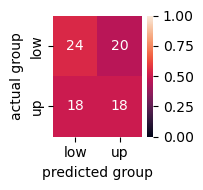

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [42]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index().rename(columns={'group' : 'trajectory', 'pat' : 'patient'})
pat_df = pat_df.merge(groups.reset_index().rename(columns={'group' : 'diagnosis'}), on='patient')
pat_df.loc[pat_df['pred'] == 0, 'pred_trajectory'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_trajectory'] = 'up'
pat_df['trajectory'] = pd.Categorical(values=pat_df['trajectory'], categories=['low', 'up'])
pat_df['pred_trajectory'] = pd.Categorical(values=pat_df['pred_trajectory'], categories=['low', 'up'])
pat_df['test correct'] = pat_df['trajectory'] == pat_df['pred_trajectory']
pat_df.set_index(['patient', 'trajectory'])

,,pred,diagnosis,pred_trajectory,test correct
patient,trajectory,,,,
P100,up,1.0,H&N cancer,up,True
P104,low,1.0,CNS-Glioma,up,False
P105,low,1.0,CNS-Meningioma,up,False
P107,low,0.0,H&N cancer,low,True
P110,low,0.0,H&N cancer,low,True
...,...,...,...,...,...
P94,up,1.0,H&N cancer,up,True
P95,up,1.0,CNS-Ependymoma,up,True
P96,up,1.0,CNS-other,up,True


In [43]:
df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})
df1.merge(df2, left_index=True, right_index=True)

/tmp/ipykernel_3721421/1486983253.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
/tmp/ipykernel_3721421/1486983253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})


test correct %  # patients
diagnosis               trajectory                            
CNS-Ependymoma          low                 100.00           4
                        up                   50.00           2
CNS-Glioma              low                  57.14           7
                        up                    0.00           2
CNS-Medulloblastoma     low                 100.00           2
                        up                    0.00           1
CNS-Meningioma          low                  16.67           6
                        up                   20.00           5
CNS-other               low                  50.00           4
                        up                   60.00           5
Chordoma/Chondrosarcoma low                  55.56           9
                        up                   75.00           4
H&N cancer              low                  60.00          10
                        up                   57.14          14
Lymphoma                low                   0.00           2
                        up                     NaN           0

## Big model

In [ ]:
name = '2_14_traj'
train_loader = up_vs_low_bagloader(use_patients=p1ts)
classifier = GatedAttention(branches=5)
loss_df = train_model(classifier, bag_loader=train_loader, 
                num_iter=100_000, lr=0.0001, device=device, fname=name, 
                save_model=True, seed=12341, plot=False,
                transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 23703; train loss: 0.47249430; train error: 0.00000000:  24%|█████████████████████████▎                                                                                 | 23703/100000 [01:34<05:01, 252.88it/s]

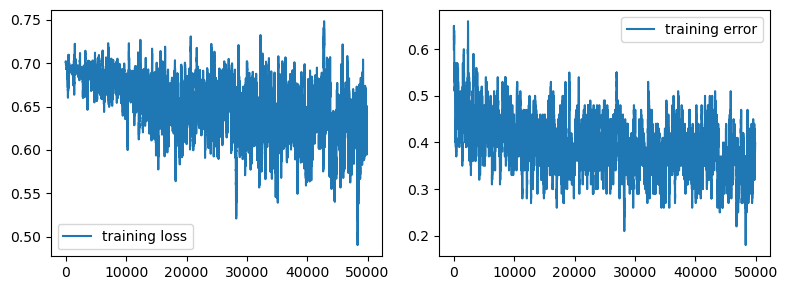

In [ ]:
w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(loss_df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(loss_df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [ ]:
name = '2_14_traj'
test_loader = test_up_vs_low_bagloader(use_patients=p1ts)
res_df, zs, imgs, masks = eval_model(name, test_loader) 
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,P100,up,0.007726,0.007735,0.009028,0.009436,0.007820,-0.655441,-0.382596,-0.328067,-0.322851,-0.403394
1,1,1.0,0,P100,up,0.005897,0.006089,0.007396,0.007637,0.005992,-0.925555,-0.621913,-0.527404,-0.534410,-0.669616
2,1,1.0,0,P100,up,0.015602,0.019021,0.020091,0.019063,0.015129,0.047329,0.517141,0.471936,0.380376,0.256556
3,1,1.0,0,P100,up,0.031578,0.041851,0.039681,0.035078,0.029828,0.752417,1.305715,1.152522,0.990206,0.935420
4,1,1.0,0,P100,up,0.006104,0.005894,0.007087,0.007508,0.006183,-0.891035,-0.654499,-0.570069,-0.551364,-0.638241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,0,0.0,901,P99,low,0.015165,0.012892,0.014689,0.015692,0.014496,0.543103,0.874883,0.780219,0.722557,0.745002
45096,0,0.0,901,P99,low,0.012092,0.008432,0.009409,0.011621,0.012728,0.316641,0.450349,0.334746,0.422240,0.614926
45097,0,0.0,901,P99,low,0.022635,0.026596,0.027099,0.026091,0.021941,0.943611,1.599013,1.392636,1.230983,1.159479
45098,0,0.0,901,P99,low,0.010988,0.008429,0.009670,0.011445,0.011411,0.220955,0.449912,0.362150,0.406911,0.505643


In [ ]:
(res_df['pred'] == res_df['lab']).mean()

0.6840354767184036

In [ ]:
np.random.seed(1234)
# vis_idx = np.random.choice(np.arange(len(res_df)), replace=False, size=5000)
vis_idx = np.arange(len(res_df))
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(zs)[vis_idx])

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


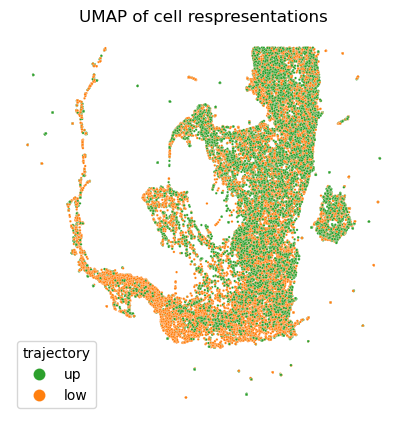

In [ ]:
res_df.loc[res_df['umap_y'] > 15, 'umap_y'] = np.nan
res_df.loc[res_df['umap_y'] < -5, 'umap_y'] = np.nan
res_df.loc[res_df['lab'] == 1, 'trajectory'] = 'up'
res_df.loc[res_df['lab'] == 0, 'trajectory'] = 'low'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='trajectory', s=3, ax=ax, palette={'up' : '#2ca02c', 'low' : '#ff7f0e'})
ax.set_title('UMAP of cell respresentations')
sns.move_legend(ax, 'best', markerscale=5)
ax.axis('off');

In [ ]:
bag_df = res_df.groupby(['pat', 'i'])[['pred', 'lab', 'group']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

82


,pat,group,correct
0,P100,up,0.636364
1,P104,low,0.363636
2,P105,low,0.909091
3,P107,low,0.909091
4,P108,up,1.000000
...,...,...,...
77,P94,up,0.636364
78,P95,up,0.636364
79,P96,up,1.000000
80,P98,up,0.000000


In [ ]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index().rename(columns={'group' : 'trajectory', 'pat' : 'patient'})
pat_df = pat_df.merge(groups.reset_index().rename(columns={'group' : 'diagnosis'}), on='patient')
pat_df.loc[pat_df['pred'] == 0, 'pred_trajectory'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_trajectory'] = 'up'
pat_df['trajectory'] = pd.Categorical(values=pat_df['trajectory'], categories=['low', 'up'])
pat_df['pred_trajectory'] = pd.Categorical(values=pat_df['pred_trajectory'], categories=['low', 'up'])
pat_df['test correct'] = pat_df['trajectory'] == pat_df['pred_trajectory']
pat_df.set_index(['patient', 'trajectory'])

,,pred,diagnosis,pred_trajectory,test correct
patient,trajectory,,,,
P100,up,1.0,H&N cancer,up,True
P104,low,1.0,CNS-Glioma,up,False
P105,low,0.0,CNS-Meningioma,low,True
P107,low,0.0,H&N cancer,low,True
P108,up,1.0,CNS-Glioma,up,True
...,...,...,...,...,...
P94,up,1.0,H&N cancer,up,True
P95,up,1.0,CNS-Ependymoma,up,True
P96,up,1.0,CNS-other,up,True


In [ ]:
df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})
df1.merge(df2, left_index=True, right_index=True)

/tmp/ipykernel_2721952/1486983253.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1 = pd.DataFrame(pat_df.reset_index().groupby(['diagnosis', 'trajectory'])['test correct'].mean() * 100).rename(columns={'test correct': 'test correct %'}).round(decimals=2)
/tmp/ipykernel_2721952/1486983253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = pd.DataFrame(pat_df.groupby(['diagnosis', 'trajectory'])['patient'].count()).rename(columns={'patient': '# patients'})


test correct %  # patients
diagnosis               trajectory                            
CNS-Ependymoma          low                  75.00           4
                        up                  100.00           2
CNS-Glioma              low                  72.73          11
                        up                   33.33           3
CNS-Medulloblastoma     low                 100.00           2
                        up                    0.00           1
CNS-Meningioma          low                  83.33           6
                        up                   40.00           5
CNS-other               low                 100.00           4
                        up                   40.00           5
Chordoma/Chondrosarcoma low                  88.89           9
                        up                   50.00           4
H&N cancer              low                 100.00          10
                        up                   71.43          14
Lymphoma                low                  50.00           2
                        up                     NaN           0

In [ ]:
print('done!')